# Precursors
The current iteration of this pipeline is coded to work only for FER2013  
Plans include room for RAFDB, CK+ and other models

In [1]:
print("Started")

Started


##### Import packages


In [2]:
import torch
import ipykernel
import numpy as np
import pandas
import torchvision.transforms as transforms
# import tqdm # progiress bar stuff, not necessary for a fully fleshed model
import sys

from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.nn import functional 
from PIL import Image
from typing import Dict, List, Tuple, Any
print("Pytorch version: ",torch.__version__)
print("Numpy version: ",np.__version__)
print("Jupyter notebook version: ",ipykernel.__version__)
seed = 42

/mnt/iusers01/fse-ugpgt01/compsci01/b84547bp/.conda/envs/Self_Model/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/iusers01/fse-ugpgt01/compsci01/b84547bp/.conda/envs/Self_Model/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Pytorch version:  2.6.0
Numpy version:  1.26.4
Jupyter notebook version:  6.31.0


#### 1. Import data and wrap around dataloaders

##### Create FERDataset Class to store datasets

In [3]:
"""
FERDataset
A class which inherits the pytorch dataset for storing and manipulating our input
"""
# Inherits Pytorch dataset
class FERDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        # Constructor
        # (String) df: Instance of pandas dataframe with data already loaded
        # (Function) transform: Image processing function 
        
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        pixels = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8)
        img = pixels.reshape(48, 48) #48x48 to match FER2013

        # from greyscale to RGB
        img = Image.fromarray(img).convert("RGB")

        label = int(row['emotion'])

        # transform img
        if self.transform:
            img = self.transform(img)

        return img, label

    def get_emotion_class(self,emotion):
        return FERDataset(self.df[self.df['emotion'] == emotion],transform=self.transform)

    @property
    def classes(self):
        classes = self.df['emotion'].unique()
        classes.sort()
        return classes
    
    # Helper function to return distribution of each class in a dataset
    @property
    def dist(self):
        return self.df['emotion'].value_counts()
    


##### Load and test the dataset (FER2013)

In [4]:
fer2013_dataframe = pandas.read_csv('./data/FER2013/train.csv')
dataset = FERDataset(dataframe=fer2013_dataframe)
print(len(dataset))
#dataset.classes
# Should be seven classes for FER2013

28709


##### Class dictionary

In [5]:
emotion_names = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

##### Grab an image and check its emotion

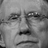

In [6]:
image, label = dataset[123]
image

In [7]:
emotion_names[label]

'Angry'

### I don't think he looks angry, but moving on

##### 2. Transform each image and recreate the dataset using the transform

In [8]:
lazytransform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
]) # lazy default transform
dataset = FERDataset(fer2013_dataframe, lazytransform)

In [9]:
image, label = dataset[0]
image.shape # Three channels, 48x48 image

torch.Size([3, 48, 48])

##### Dataloaders  
For batching our dataset

In [10]:
batch_size = 32
dataloader = DataLoader(dataset,batch_size, shuffle=True)

At the end of this section, we have created the FERDataset class, which takes
- A pandas dataframe
- A preprocessing function for the data

As a result, we can get
- The length of the dataset
- The next item in the dataset

# 2. Create model

## [Using this as source](https://www.kaggle.com/code/galiasamuel/emotion-recognition-using-fer-dataset-resnet18)

In [11]:
# Hardware boilerplate
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# Import Resnet
from torchvision.models import resnet18, ResNet18_Weights
resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [13]:
resnet_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [14]:
# Need to replace output layer with the number of classes our FER dataset has
# Get the number of input features for the final fully connected layer
num_ftrs = resnet_model.fc.in_features
num_classes = 7 # no of classes in our data

# Replace the final fully connected layer
resnet_model.fc = nn.Sequential(
    # First hidden layer (Input: num_ftrs, Output: 512 nodes)
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5), # Slightly higher dropout rate example

    # Second hidden layer (Input: 512, Output: 256 nodes)
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5), # Apply dropout again

    # Output layer (Input: 256, Output: 7 classes)
    nn.Linear(256, 7)
)

# Move model to device
resnet_model.to(device)

# Look at the final layer again
resnet_model.fc

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=256, out_features=7, bias=True)
)

In [15]:
# The kaggle model notes resne18's default transformations
ResNet18_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
# Consts for mean and st.dev
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
TARGET_SIZE = 224

In [17]:
# This code needs to be modified to deal with
# Transforms for the training set (includes augmentation)
train_transforms_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3 channels by repeating
    transforms.Resize(256),                      # Resize the image (typically the shorter side) to 256
    transforms.RandomCrop(TARGET_SIZE),          # Take a random 224x224 crop for data augmentation
    transforms.RandomHorizontalFlip(),           # Standard data augmentation
    transforms.RandomRotation(degrees=10),       # add slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # add brightness/contrast jitter
    transforms.ToTensor(),                       # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize with ImageNet values
])

# Transforms for the validation/testing set (deterministic preprocessing)
val_transforms_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3 channels
    transforms.Resize(256),                      # Resize the image (typically the shorter side) to 256
    transforms.CenterCrop(TARGET_SIZE),          # Take the central 224x224 crop for evaluation
    transforms.ToTensor(),                       # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize with ImageNet values
])

In [18]:
# We can access the distribution of each emotion using our helper property dataset.dist
dataset.dist
val_size = (int(0.2*dataset.dist[0]))
train_size = dataset.dist[0]-val_size

In [19]:
# The kaggle dataset uses a stratified split between training and validation
# So I'll have to hack my way around creating my own version based on the kaggle code
def Strat_Split(
        dataset : FERDataset,
        pct : float,
        emotion : int
        ):
    generator = torch.Generator().manual_seed(seed)

    #print(len(dataset))
    # print(dataset.transform)
    # Define train and val dataset size
    val_size = int(pct*dataset.dist[emotion])
    train_size = dataset.dist[emotion]-val_size
    train_dataset, val_dataset = random_split(dataset,[train_size,val_size],generator=generator)
    
    return train_dataset, val_dataset

In [20]:
# He uses a "ConcatDataset" to join the disjoint datasets
train_datasets = list()
val_datasets = list()
dataset = FERDataset(fer2013_dataframe,transform = train_transforms_resnet)
for emotion in dataset.classes:
    # Create our stratified splits
    dataset_emot = dataset.get_emotion_class(emotion)
    print(emotion_names[emotion],":",len(dataset_emot))
    train_emot, val_emot = Strat_Split(dataset_emot, 0.2, emotion)
    # And append them together
    train_datasets.append(train_emot)
    val_datasets.append(val_emot)
    
train_ds = ConcatDataset(train_datasets)
val_ds = ConcatDataset(val_datasets)

Angry : 3995
Disgust : 436
Fear : 4097
Happy : 7215
Sad : 4830
Surprise : 3171
Neutral : 4965


In [21]:
train_ds.transform = train_transforms_resnet
val_ds.transform = val_transforms_resnet

In [22]:
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

#### FER2013 has been split into stratified sets, and now can be used with ResNet18

### The next parts of the implementation of the model are directly from the kaggle codebase, I might tinker with it in the future

In [23]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               scheduler: torch.optim.lr_scheduler.OneCycleLR) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. (added) Scheduler step
        scheduler.step()
        

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# EDITED FOR PERFORMANCE AND TO IMPLEMENT EARLY STOPPING

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, # Renamed from test_dataloader to val_dataloader for clarity with validation set
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          scheduler: torch.optim.lr_scheduler.OneCycleLR, # Type hint specific OneCycleLR as used
          device: torch.device,
          # --- Early Stopping Parameters ---
          patience: int = 10, # How many epochs to wait for improvement before stopping
          min_delta: float = 0.0 # Minimum change to qualify as improvement
          # ---------------------------------
         ) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model with Early Stopping.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop. Stops early if validation performance
    doesn't improve for 'patience' epochs.

    Calculates, prints and stores evaluation metrics throughout.
    Saves the best model state based on validation accuracy.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be validated on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for (maximum).
        scheduler: A PyTorch learning rate scheduler (assumed to be stepped per batch).
        device: A target device to compute on (e.g. "cuda" or "cpu").
        patience: Number of epochs to wait for improvement in validation accuracy.
        min_delta: Minimum change in validation accuracy to be considered an improvement.

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics tracked per epoch. The input 'model' object
        will be updated in-place with the best weights found during training
        (based on validation accuracy).
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [], # Renamed from test_loss to val_loss
               "test_acc": []  # Renamed from test_acc to val_acc
    }

    # --- Early Stopping Initialization ---
    best_val_accuracy = -float('inf') # Initialize best accuracy to a very low value
    patience_counter = 0             # Initialize patience counter
    best_model_state_dict = None     # To store the state_dict of the best model
    print(f"Early stopping configured with patience={patience}, min_delta={min_delta}")
    # ------------------------------------


    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Assuming train_step includes scheduler.step() per batch
        train_loss, train_acc = train_step(model=model,
                                             dataloader=train_dataloader,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             device=device,
                                             scheduler=scheduler) # Pass scheduler

        # Assuming test_step is the validation step
        val_loss, val_acc = test_step(model=model, # Renamed test_step calls to clarify validation
                                          dataloader=test_dataloader, # Using test_dataloader as val_dataloader
                                          loss_fn=loss_fn,
                                          device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | " # Renamed print output
            f"val_acc: {val_acc:.4f}"     # Renamed print output
        )

        # --- Early Stopping Logic ---
        # Check for improvement in validation accuracy
        if val_acc > best_val_accuracy + min_delta:
            best_val_accuracy = val_acc
            patience_counter = 0 # Reset patience counter on improvement
            # Save the model state dictionary
            # Use copy.deepcopy() to save a true copy, not just a reference
            best_model_state_dict = deepcopy(model.state_dict())
            print(f"  Validation accuracy improved. Saving best model state (Acc: {best_val_accuracy:.4f})")
        else:
            patience_counter += 1 # Increment patience counter if no improvement
            print(f"  Validation accuracy did not improve. Patience: {patience_counter}/{patience}")

        # Check if early stopping condition is met
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break # Exit the training loop
        """
        we dont use wandb
        # --- End Early Stopping Logic ---
        # Log metrics to wandb
        run.log({"epoch": epoch+1,
               "train_loss": train_loss,
               "train_acc": train_acc,
               "test_loss": val_loss,
               "test_acc": val_acc})
        
        """
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(val_loss) # Store as test_loss in results dict for consistency if needed later
        results["test_acc"].append(val_acc)   # Store as test_acc in results dict


    # --- Load the best model state after training stops ---
    if best_model_state_dict is not None:
        print("Loading best model state found during training.")
        model.load_state_dict(best_model_state_dict)
    else:
         print("No improvement was found during training. Using the model from the last epoch.")


    # Return the filled results at the end of the epochs
    return results

In [24]:

from fastai.vision.all import *
# defining the DataLoaders object in FastAI using both train and val datasets
dls = DataLoaders(train_dataloader, val_dataloader)
# wrapping our dataloader in a fastai learner
learn = Learner(
    dls, resnet_model,
    loss_func=CrossEntropyLossFlat(), 
    opt_func=SGD,
    metrics=accuracy
)

SuggestedLRs(valley=0.009120108559727669)


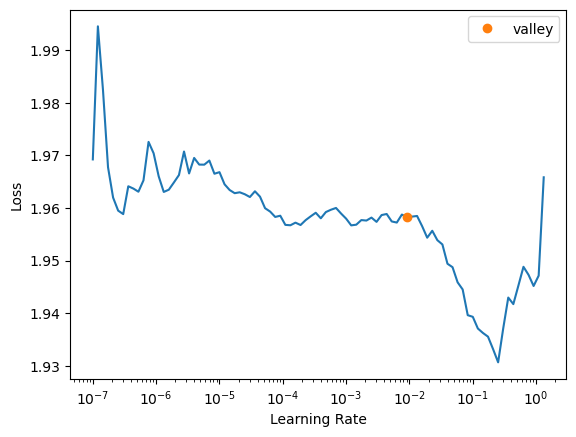

In [25]:
# finding the learning rate
lr_result = learn.lr_find()
print(lr_result)

In [26]:
lr = float(lr_result.valley)
lr

0.009120108559727669

Suggested LR is 0.009120108559727669

In [27]:
learning_rate = lr
# define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# defining the optimizer, this time using SGD
optimizer = optim.SGD(
    resnet_model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4)

# define the number of epochs
num_epochs = 50

# adding a learning rate scheduler (OneCycleLR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs)

Begin training

In [ ]:
# Set number of epochs again for clarity
num_epochs = 50 

# set patience value for early stopping
patience_value = 10

# Start the timer
# from timeit import default_timer as timer
# start_time = timer()

# Call the training function with early stopping parameters
resnet18_results = train(model=resnet_model,
                         train_dataloader=train_dataloader,
                         test_dataloader=val_dataloader,
                         optimizer=optimizer,
                         loss_fn=criterion,
                         epochs=num_epochs,
                         scheduler=scheduler,
                         device=device,
                         patience=patience_value,
                         min_delta=0.0001
                         )

# End the timer and print out how long it took
# end_time = timer()
# print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Early stopping configured with patience=10, min_delta=0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7428 | train_acc: 0.2873 | val_loss: 1.4836 | val_acc: 0.4482
  Validation accuracy improved. Saving best model state (Acc: 0.4482)
Epoch: 2 | train_loss: 1.3835 | train_acc: 0.4666 | val_loss: 1.2080 | val_acc: 0.5400
  Validation accuracy improved. Saving best model state (Acc: 0.5400)
Epoch: 3 | train_loss: 1.2152 | train_acc: 0.5380 | val_loss: 1.1120 | val_acc: 0.5764
  Validation accuracy improved. Saving best model state (Acc: 0.5764)
Epoch: 4 | train_loss: 1.1212 | train_acc: 0.5795 | val_loss: 1.0540 | val_acc: 0.6079
  Validation accuracy improved. Saving best model state (Acc: 0.6079)
Epoch: 5 | train_loss: 1.0681 | train_acc: 0.6079 | val_loss: 1.0559 | val_acc: 0.6070
  Validation accuracy did not improve. Patience: 1/10
Epoch: 6 | train_loss: 1.0293 | train_acc: 0.6232 | val_loss: 0.9978 | val_acc: 0.6293
  Validation accuracy improved. Saving best model state (Acc: 0.6293)
Epoch: 7 | train_loss: 0.9930 | train_acc: 0.6365 | val_loss: 1.0032 | val

First run results:

Epoch: 34 | train_loss: 0.3949 | train_acc: 0.8612 | val_loss: 1.1834 | val_acc: 0.6597
  Validation accuracy did not improve. Patience: 8/10
Epoch: 35 | train_loss: 0.3553 | train_acc: 0.8754 | val_loss: 1.2114 | val_acc: 0.6694
  Validation accuracy did not improve. Patience: 9/10
Epoch: 36 | train_loss: 0.3417 | train_acc: 0.8815 | val_loss: 1.2571 | val_acc: 0.6657
  Validation accuracy did not improve. Patience: 10/10
Early stopping triggered after 36 epochs.
Loading best model state found during training.

0.6657% accuracy

In [ ]:
testdf = pandas.read_csv('./data/FER2013/test.csv')
test_ds = FERDataset(testdf,transform=val_transforms_resnet)
test_dataloader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
)
print(next(iter(test_dataloader)))

In [ ]:
from sklearn.metrics import classification_report

# Evaluate model
resnet_model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report as dictionary
report_dict = classification_report(
    all_labels, 
    all_preds, 
    target_names=full_data.classes, 
    output_dict=True
)

# Print report
print(classification_report(all_labels, all_preds, target_names=full_data.classes))

# Flatten and log to wandb
flattened_report = {}
for label, metrics in report_dict.items():
    if isinstance(metrics, dict):
        for metric_name, value in metrics.items():
            flattened_report[f"{label}/{metric_name}"] = value
    else:
        flattened_report[label] = metrics


